In [1]:
"""
Analyse des profils nutritionnels et clustering
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [2]:
def load_data():
    """Charge et prépare les données"""
    df = pd.read_csv("../data/RAW_recipes.csv")
    
    # Extraire nutrition
    df['calories'] = df['nutrition'].apply(lambda x: eval(x)[0])
    df['total_fat'] = df['nutrition'].apply(lambda x: eval(x)[1])
    df['sugar'] = df['nutrition'].apply(lambda x: eval(x)[2])
    df['sodium'] = df['nutrition'].apply(lambda x: eval(x)[3])
    df['protein'] = df['nutrition'].apply(lambda x: eval(x)[4])
    df['saturated_fat'] = df['nutrition'].apply(lambda x: eval(x)[5])
    df['carbohydrates'] = df['nutrition'].apply(lambda x: eval(x)[6])
    
    # Filtrer outliers
    df = df[
        (df['calories'] <= 2000) &
        (df['total_fat'] <= 200) &
        (df['sugar'] <= 200) &
        (df['protein'] <= 200)
    ]
    
    return df

In [3]:
def categorize_by_calories(df):
    """Catégorise par niveau calorique"""
    
    print("\n" + "="*60)
    print("CATÉGORISATION PAR CALORIES")
    print("="*60)
    
    df['calorie_level'] = pd.cut(
        df['calories'],
        bins=[0, 200, 400, 600, 2000],
        labels=['Léger', 'Modéré', 'Riche', 'Très riche']
    )
    
    calorie_counts = df['calorie_level'].value_counts()
    
    print(f"\n Distribution par niveau calorique:")
    for level in ['Léger', 'Modéré', 'Riche', 'Très riche']:
        if level in calorie_counts.index:
            count = calorie_counts[level]
            pct = count / len(df) * 100
            print(f"  {level:12s} : {count:6,} recettes ({pct:5.1f}%)")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Distribution des calories
    axes[0].hist(df['calories'], bins=50, edgecolor='black', alpha=0.7, color='salmon')
    axes[0].axvline(df['calories'].median(), color='green', linestyle='--', linewidth=2, 
                    label=f'Médiane = {df["calories"].median():.0f} cal')
    axes[0].set_xlabel('Calories', fontsize=12)
    axes[0].set_ylabel('Fréquence', fontsize=12)
    axes[0].set_title('Distribution des calories', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart
    colors = ['#90EE90', '#FFD700', '#FF8C00', '#DC143C']
    axes[1].pie(calorie_counts, labels=calorie_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[1].set_title('Répartition par niveau calorique', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    plt.show()

In [4]:
def nutrition_clustering(df):
    """Clustering des profils nutritionnels"""
    
    print("\n" + "="*60)
    print("CLUSTERING DES PROFILS NUTRITIONNELS")
    print("="*60)
    
    # Préparer les données
    nutrition_cols = ['calories', 'total_fat', 'sugar', 'protein', 'carbohydrates']
    X = df[nutrition_cols].dropna()
    
    # Normaliser
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means avec 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Ajouter les clusters au dataframe
    df_clustered = df.loc[X.index].copy()
    df_clustered['nutrition_cluster'] = clusters
    
    # Analyser les clusters
    print(f"\n Profils nutritionnels identifiés:")
    
    cluster_names = {
        0: 'Profil 1',
        1: 'Profil 2',
        2: 'Profil 3',
        3: 'Profil 4'
    }
    
    for i in range(4):
        cluster_data = df_clustered[df_clustered['nutrition_cluster'] == i]
        print(f"\n  {cluster_names[i]} ({len(cluster_data):,} recettes - {len(cluster_data)/len(df_clustered)*100:.1f}%):")
        print(f"    Calories:     {cluster_data['calories'].mean():>6.0f} kcal")
        print(f"    Protéines:    {cluster_data['protein'].mean():>6.1f} g")
        print(f"    Glucides:     {cluster_data['carbohydrates'].mean():>6.1f} g")
        print(f"    Lipides:      {cluster_data['total_fat'].mean():>6.1f} g")
        print(f"    Sucres:       {cluster_data['sugar'].mean():>6.1f} g")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Scatter plot calories vs protéines
    scatter = axes[0].scatter(df_clustered['protein'], df_clustered['calories'], 
                              c=df_clustered['nutrition_cluster'], cmap='viridis', 
                              alpha=0.3, s=10)
    axes[0].set_xlabel('Protéines (g)', fontsize=12)
    axes[0].set_ylabel('Calories', fontsize=12)
    axes[0].set_title('Clusters nutritionnels (Calories vs Protéines)', 
                      fontsize=13, fontweight='bold')
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    axes[0].grid(alpha=0.3)
    
    # Radar chart des profils moyens
    categories = ['Calories\n(x10)', 'Lipides\n(x5)', 'Sucres', 'Protéines', 'Glucides']
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax = plt.subplot(122, projection='polar')
    
    for i in range(4):
        cluster_data = df_clustered[df_clustered['nutrition_cluster'] == i]
        values = [
            cluster_data['calories'].mean() / 10,  # Normaliser pour la visualisation
            cluster_data['total_fat'].mean() * 5,
            cluster_data['sugar'].mean(),
            cluster_data['protein'].mean(),
            cluster_data['carbohydrates'].mean()
        ]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Profil {i+1}')
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=9)
    ax.set_title('Profils nutritionnels moyens', fontsize=13, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
 
    plt.show()

In [5]:
def healthy_vs_indulgent(df):
    """Comparaison recettes healthy vs indulgent"""
    
    print("\n" + "="*60)
    print("HEALTHY VS INDULGENT")
    print("="*60)
    
    # Critères "healthy" : <400 cal, <15g fat, <10g sugar
    df['is_healthy'] = (
        (df['calories'] < 400) & 
        (df['total_fat'] < 15) & 
        (df['sugar'] < 10)
    )
    
    healthy_count = df['is_healthy'].sum()
    indulgent_count = len(df) - healthy_count
    
    print(f"\n Classification:")
    print(f"  Healthy:    {healthy_count:6,} recettes ({healthy_count/len(df)*100:.1f}%)")
    print(f"  Indulgent:  {indulgent_count:6,} recettes ({indulgent_count/len(df)*100:.1f}%)")
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(8, 6))
    
    labels = ['Healthy', 'Indulgent']
    sizes = [healthy_count, indulgent_count]
    colors = ['#90EE90', '#FFB6C1']
    explode = (0.1, 0)
    
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
           shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title('Recettes Healthy vs Indulgent', fontsize=14, fontweight='bold')
    

    plt.show()

 Chargement des données...
 211,355 recettes chargées


CATÉGORISATION PAR CALORIES

 Distribution par niveau calorique:
  Léger        : 69,312 recettes ( 32.8%)
  Modéré       : 73,714 recettes ( 34.9%)
  Riche        : 39,044 recettes ( 18.5%)
  Très riche   : 29,232 recettes ( 13.8%)


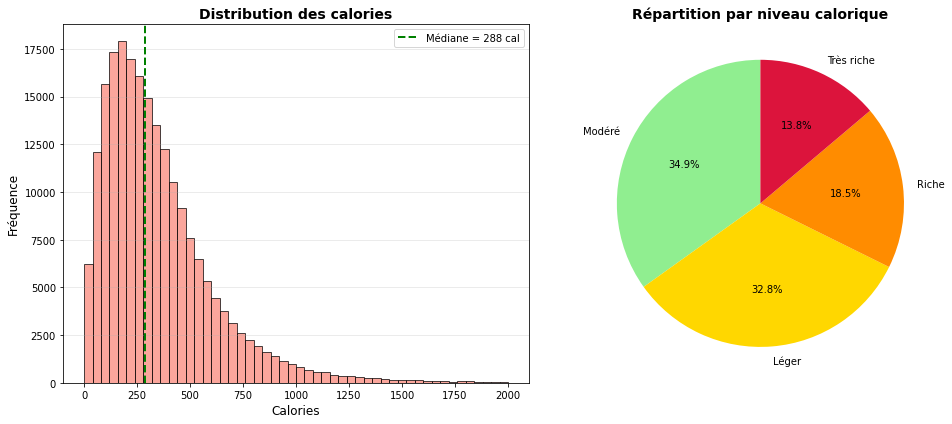


CLUSTERING DES PROFILS NUTRITIONNELS

 Profils nutritionnels identifiés:

  Profil 1 (102,290 recettes - 48.4%):
    Calories:        168 kcal
    Protéines:      12.2 g
    Glucides:        5.5 g
    Lipides:        11.6 g
    Sucres:         21.9 g

  Profil 2 (60,781 recettes - 28.8%):
    Calories:        469 kcal
    Protéines:      55.1 g
    Glucides:       10.8 g
    Lipides:        37.4 g
    Sucres:         21.7 g

  Profil 3 (31,711 recettes - 15.0%):
    Calories:        361 kcal
    Protéines:      14.5 g
    Glucides:       16.1 g
    Lipides:        23.2 g
    Sucres:        120.8 g

  Profil 4 (16,573 recettes - 7.8%):
    Calories:        992 kcal
    Protéines:      89.8 g
    Glucides:       23.6 g
    Lipides:        88.5 g
    Sucres:         42.8 g


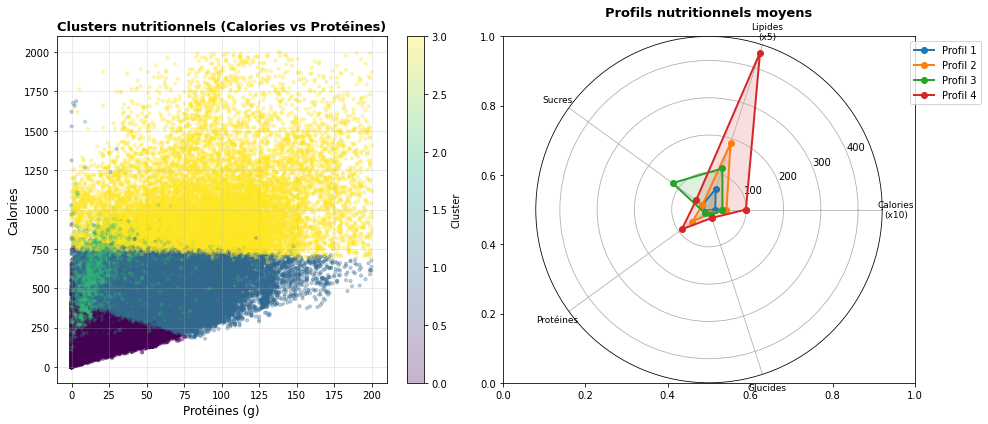


HEALTHY VS INDULGENT

 Classification:
  Healthy:    25,809 recettes (12.2%)
  Indulgent:  185,546 recettes (87.8%)


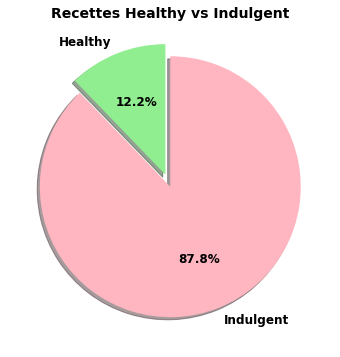

In [6]:
def main():
    """Fonction principale"""
    
    print(" Chargement des données...")
    df = load_data()
    print(f" {len(df):,} recettes chargées\n")
    
    categorize_by_calories(df)
    nutrition_clustering(df)
    healthy_vs_indulgent(df)


if __name__ == "__main__":
    main()